# Earthquake damage classification

## 07 January 2020, Mw6.4 Puerto Rico Earthquake 🇵🇷

## Step 0: Preliminaries

### Import python libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import rasterio
import rasterio.mask
import folium
import seaborn as sns
%matplotlib inline

### Set the default coordinate reference system

In [2]:
dst_crs = "EPSG:4326"

## Step 1: Demarcate affected area

### Draw an empty map centered on the event

In [3]:
lat = +17.92
lon = -66.81

bound_n = +20.0
bound_e = -68.5
bound_s = +17.5
bound_w = -65.0

m = folium.Map(
    location=[lat, lon], 
    zoom_start=10,
    tiles='Stamen Terrain')

folium.CircleMarker(
    location=[lat, lon],
    radius=5,
    tooltip="Epicenter",
    popup="M6.4 Puerto Rico Earthquake",
    color="IndianRed",
    fill_color="LightCoral",
    fill=True
).add_to(m)

m

### Draw ShakeMap contours for MMI ≥ V

In [4]:
shakemap_url = "https://earthquake.usgs.gov/archive/product/shakemap/us70006vll/us/1584809671137/download/cont_mmi.json"

style_function = lambda x: {
    'color': x["properties"]["color"],
    'weight': x["properties"]["weight"] if x["properties"]["value"] >= 5 else 0
}
tooltip = folium.features.GeoJsonTooltip(fields=["value"])

folium.GeoJson(
    shakemap_url,
    name="ShakeMap Contours",
    style_function=style_function,
    tooltip=tooltip
).add_to(m)

folium.TileLayer('OpenStreetMap').add_to(m)
folium.LayerControl().add_to(m)

m

### Save the MMI V contour as a vector layer

In [5]:
shakemapV_envelope_file = "ShakeMap/Puerto_Rico/MMI_V.shp"
shakemap_gdf = gpd.read_file(shakemap_url)
shakemapV_gdf = shakemap_gdf[shakemap_gdf.value==5]
shakemapV_gdf.to_file(shakemapV_envelope_file, driver="GPKG")
shakemapV_gdf.convex_hull.to_file(shakemapV_envelope_file)

## Step 2: Load DPM tiles and mask to built areas within MMI≥V

### Read the DPM raster and mask it using the MMI V contour

In [6]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
in_path = "DPM/ARIA_DPM2raw_Sentinel-1_T98_v0.9.tif"
out_path = "DPM/ARIA_DPM2raw_Sentinel-1_T98_v0.9_ShakeMapMask.tif"

with fiona.open("ShakeMap/MMI_V.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(in_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(out_path, "w", **out_meta) as dest:
    dest.write(out_image)

### Plot the clipped DPM raster

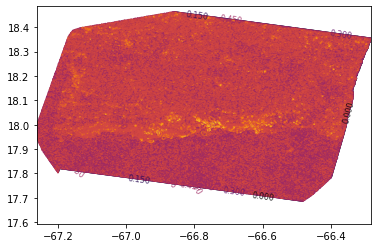

<AxesSubplot:>

In [7]:
from rasterio.plot import show
dpm_src = rasterio.open(out_path)
show(dpm_src, cmap='inferno', contour=True)

### Explore the distribution of the clipped DPM pixel values by plotting a histogram

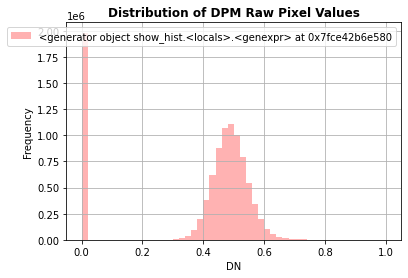

In [8]:
from rasterio.plot import show_hist
show_hist(
    dpm_src, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Distribution of DPM Raw Pixel Values")

### Overlay the DPM raster on the map

In [ ]:
# Read the clipped DPM raster file
with rasterio.open(out_path) as dpm_src:
    boundary = dpm_src.bounds
    img = dpm_src.read()
    nodata = dpm_src.nodata

In [ ]:
# Add the clipped DPM raster to the existing map
# This step can be computationally intensive
# Can be skipped
m.add_child(
    folium.raster_layers.ImageOverlay(
        img[0],
        name="DPM Raster",
        opacity=.25,
        bounds=[[bound_s, bound_w], [bound_n, bound_e]],
        colormap=plt.cm.viridis))
folium.LayerControl().add_to(m)

In [ ]:
# Display the map with the DPM raster overlay
# On some browsers the raster may fail to display
m

## Step 3: Load and plot the building inventory files

### Load the building inventory file for Puerto Rico

In [13]:
bldgs_all =  "Buildings/Puerto_Rico_Building_Footprints.gpkg"
bldgs_gdf = gpd.read_file(bldgs_all)

### Inspect the building inventory file

In [14]:
bldgs_gdf.head()

,osm_id,name,building,geometry
0,22085240,None,detached,"MULTIPOLYGON (((-66.69891 18.16921, -66.69890 ..."
1,22119198,None,detached,"MULTIPOLYGON (((-67.16058 18.08564, -67.16056 ..."
2,22121360,None,detached,"MULTIPOLYGON (((-67.16083 18.08558, -67.16082 ..."
3,22121396,None,detached,"MULTIPOLYGON (((-67.16079 18.08547, -67.16078 ..."
4,22122009,None,detached,"MULTIPOLYGON (((-67.16062 18.08580, -67.16059 ..."


### (Try to) plot the building footprints on the map

In [ ]:
folium.GeoJson(
    zagreb_bldgs_all,
    name="Building Footprints"
).add_to(m)

folium.LayerControl().add_to(m)

In [ ]:
m

## Step 4: Join the damage labels to the building inventory

### Load the damage labels ("ground truth" / "test labels")

In [ ]:
# # Use Copernicus / UNITAR damage labels as proxy test labels if 
# # detailed damage data is not available for the event
# copernicus_damage_labels = "../../Copernicus/Zagreb/P08_damage_assessment_WGS84.gpkg"

In [20]:
damage_labels = "DamageLabels/DamageAssessment_BuildingFootprints.gpkg"
dmg_labels_gdf = gpd.read_file(damage_labels)

### Inspect the damage labels layer contents

In [21]:
dmg_labels_gdf.head()

,osm_id,name,building,damage_cat,geometry
0,22085240,None,detached,None,"MULTIPOLYGON (((-66.69891 18.16921, -66.69890 ..."
1,22119198,None,detached,None,"MULTIPOLYGON (((-67.16058 18.08564, -67.16056 ..."
2,22121360,None,detached,None,"MULTIPOLYGON (((-67.16083 18.08558, -67.16082 ..."
3,22121396,None,detached,None,"MULTIPOLYGON (((-67.16079 18.08547, -67.16078 ..."
4,22122009,None,detached,None,"MULTIPOLYGON (((-67.16062 18.08580, -67.16059 ..."


In [17]:
dmg_labels_gdf.columns

Index(['osm_id', 'name', 'building', 'damage_cat', 'geometry'], dtype='object')

In [22]:
# Drop unnecessary columns
dmg_labels_gdf.drop(columns=["name", "building"], inplace=True)

# Rename fields
dmg_labels_gdf.rename(columns={"damage_cat": "DAMAGE_GRADE"}, inplace=True)

# Inspect contents of the revised files
dmg_labels_gdf.head()

,osm_id,DAMAGE_GRADE,geometry
0,22085240,None,"MULTIPOLYGON (((-66.69891 18.16921, -66.69890 ..."
1,22119198,None,"MULTIPOLYGON (((-67.16058 18.08564, -67.16056 ..."
2,22121360,None,"MULTIPOLYGON (((-67.16083 18.08558, -67.16082 ..."
3,22121396,None,"MULTIPOLYGON (((-67.16079 18.08547, -67.16078 ..."
4,22122009,None,"MULTIPOLYGON (((-67.16062 18.08580, -67.16059 ..."


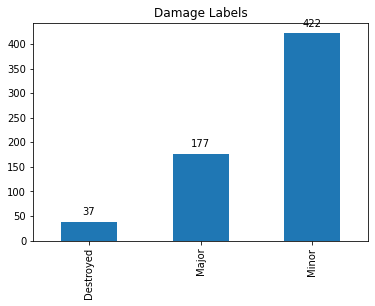

In [23]:
# Inspect the damage grade labels column
ax = (dmg_labels_gdf.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Damage Labels"
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

In [24]:
# Relabel damage grades for use in the training and testing module with integer values
dmg_labels_gdf.replace(
    to_replace={"DAMAGE_GRADE":{
        "Minor": "1",
        "Major": "2",
        "Destroyed": "3"}},
    inplace=True)

# Inspect the damage grades database
dmg_labels_gdf.head()

,osm_id,DAMAGE_GRADE,geometry
0,22085240,None,"MULTIPOLYGON (((-66.69891 18.16921, -66.69890 ..."
1,22119198,None,"MULTIPOLYGON (((-67.16058 18.08564, -67.16056 ..."
2,22121360,None,"MULTIPOLYGON (((-67.16083 18.08558, -67.16082 ..."
3,22121396,None,"MULTIPOLYGON (((-67.16079 18.08547, -67.16078 ..."
4,22122009,None,"MULTIPOLYGON (((-67.16062 18.08580, -67.16059 ..."


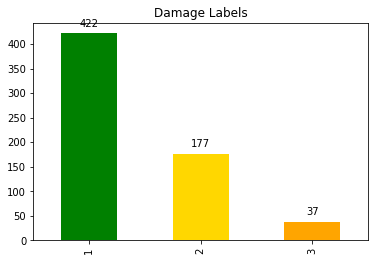

In [25]:
# Inspect the damage grade labels column after the relabeling
ax = (dmg_labels_gdf.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Damage Labels",
          color=["Green", "Gold", "Orange", "IndianRed"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

In [26]:
# Inspect the coordinate reference system used by the damage database
dmg_labels_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
# Reproject the damage dataset to the project coordinate reference system
dmg_labels_gdf = dmg_labels_gdf.to_crs(dst_crs)

### Join the damage labels to the building inventory

#### Buffer the points in the damage database to expand each point into a circle of 2m radius

In [39]:
# Buffer each point using a 1 meter buffer zone 
# and replace the point geometry with the new buffered geometry
# The damage database is in the EPSG:3857 CRS, thus the buffer distance is in metres
dmg_labels_buffer_gdf = dmg_labels_gdf.copy()
dmg_labels_buffer_gdf["geometry"] = dmg_labels_gdf.to_crs("EPSG:3857").buffer(1).to_crs(dst_crs)
dmg_labels_buffer_gdf.head()

,osm_id,DAMAGE_GRADE,geometry
0,22085240,None,"POLYGON ((-66.69891 18.16921, -66.69881 18.169..."
1,22119198,None,"POLYGON ((-67.16058 18.08565, -67.16047 18.085..."
2,22121360,None,"POLYGON ((-67.16083 18.08559, -67.16083 18.085..."
3,22121396,None,"POLYGON ((-67.16079 18.08548, -67.16079 18.085..."
4,22122009,None,"POLYGON ((-67.16062 18.08580, -67.16051 18.085..."


In [40]:
# Create a buffered polygon layer from the buildings layer
bldgs_buffer_gdf = bldgs_gdf.copy()

# Buffer each point using a 2 meter buffer zone 
# and replace the point geometry with the new buffered geometry
bldgs_buffer_gdf["geometry"] = bldgs_gdf.to_crs("EPSG:3857").buffer(5).to_crs(dst_crs)
bldgs_buffer_gdf.head()

,osm_id,name,building,geometry
0,22085240,None,detached,"POLYGON ((-66.69891 18.16925, -66.69881 18.169..."
1,22119198,None,detached,"POLYGON ((-67.16059 18.08568, -67.16048 18.085..."
2,22121360,None,detached,"POLYGON ((-67.16087 18.08560, -67.16087 18.085..."
3,22121396,None,detached,"POLYGON ((-67.16083 18.08549, -67.16083 18.085..."
4,22122009,None,detached,"POLYGON ((-67.16063 18.08584, -67.16052 18.085..."


In [41]:
#Intersect those buffered circles with the bufferered building footprint polygons
input_gdf = gpd.sjoin(
    bldgs_buffer_gdf,
    dmg_labels_buffer_gdf,
    how="left",
    op="intersects")

In [42]:
# Assign buildings with no damage label to "No damage"
input_gdf.fillna(value={"DAMAGE_GRADE": "0"}, inplace=True)

In [43]:
input_gdf.head()

,osm_id_left,name,building,geometry,index_right,osm_id_right,DAMAGE_GRADE
0,22085240,None,detached,"POLYGON ((-66.69891 18.16925, -66.69881 18.169...",0,22085240,0
1,22119198,None,detached,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",237284,536066031,0
1,22119198,None,detached,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",1,22119198,0
1,22119198,None,detached,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",4,22122009,0
2,22121360,None,detached,"POLYGON ((-67.16087 18.08560, -67.16087 18.085...",3,22121396,0


In [44]:
# Drop unneeded columns and inspect the newly joined database
input_gdf.drop(columns=["osm_id_left", "osm_id_right", "index_right", "name", "building"], inplace=True)
input_gdf.head()

,geometry,DAMAGE_GRADE
0,"POLYGON ((-66.69891 18.16925, -66.69881 18.169...",0
1,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",0
1,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",0
1,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",0
2,"POLYGON ((-67.16087 18.08560, -67.16087 18.085...",0


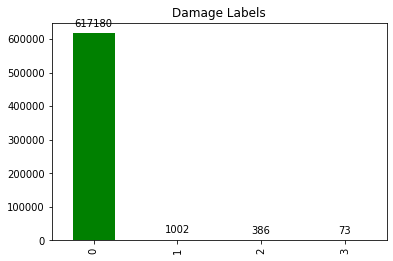

In [47]:
# Inspect the damage grade labels column after the join
# We expect to see a lot more buildings in no damage
ax = (input_gdf.DAMAGE_GRADE
      .astype(int)
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Damage Labels",
          color=["Green", "Gold", "Orange", "IndianRed"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

#### Note: This is an imbalanced dataset
The number of samples in Damage Grade "0" is roughly four orders of magnitude larger than the number of samples in Damage Grade "3". Most machine learning multiclass classification algorithms assume that all classes have roughly similar numbers of examples. 

To circumvent this issue, one potential route is to modify the training set to have similar numbers of examples in each category, for instance by oversampling training examples from the classes with fewer examples.

Another route is to modify the classification algorithm by changing the way learning is performed, preferably biasing more towards those classes that have fewer examples in the training dataset. This is generally called cost-sensitive learning.

We will initially run the algorithms without modifying either the dataset or the algorithms themselves. 

## Step 5. Join ShakeMap intensity to building inventory

### Join ShakeMap value to the building inventory

In [49]:
shakemap_file = "ShakeMap/mi.shp"
shakemap_gdf = gpd.read_file(shakemap_file)
inputs_gdf = gpd.sjoin(input_gdf, shakemap_gdf, how="left", op="within")

In [50]:
# Drop unneeded columns and rename the remaining ones
inputs_gdf.drop(columns=["index_right", "AREA", "PERIMETER", "PGAPOL_", "PGAPOL_ID", "GRID_CODE"], inplace=True)
inputs_gdf.rename(columns={"Area": "AREA", "layer": "BLDG_TYPE", "PARAMVALUE": "MMI"}, inplace=True)

In [51]:
# Assign buildings with no shaking intensity to a value of MMI=0
inputs_gdf.fillna(value={"MMI": 0}, inplace=True)

In [52]:
inputs_strings = inputs_gdf.astype({"MMI": str, "DAMAGE_GRADE":str})
inputs_numeric = inputs_gdf.astype({"MMI": float, "DAMAGE_GRADE":int})

In [53]:
# Inspect the joined dataset
inputs_numeric.head()

,geometry,DAMAGE_GRADE,MMI
0,"POLYGON ((-66.69891 18.16925, -66.69881 18.169...",0,5.6
1,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",0,5.4
1,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",0,5.4
1,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",0,5.4
2,"POLYGON ((-67.16087 18.08560, -67.16087 18.085...",0,5.4


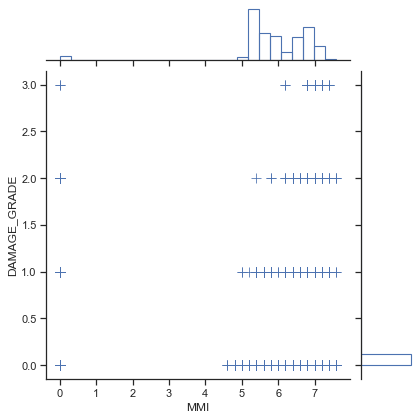

In [54]:
sns.set_theme(style="ticks")
sns.jointplot(
    data=inputs_numeric, 
    x="MMI", y="DAMAGE_GRADE", 
    marker="+", s=100, 
    marginal_kws=dict(bins=25, fill=False),
)

## Step 6. Join DPM values to the input dataset

### Find the maximum DPM value falling within each buffered building polygon

In [55]:
# This step can take several minutes, depending on the sizes
# of the building inventory + damage database and the DPM raster
import rasterstats as rs

original_dpm = "DPM/ARIA_DPM2raw_Sentinel-1_T98_v0.9.tif"
clipped_dpm = "DPM/ARIA_DPM2raw_Sentinel-1_T98_v0.9_ShakeMapMask.tif"

with rasterio.open(clipped_dpm) as dpm_src:
    dpm_data = dpm_src.read(1, masked=True)
    dpm_meta = dpm_src.profile
    
inputs_gdf = rs.zonal_stats(
    inputs_numeric,
    dpm_data,
    nodata=-999,
    affine=dpm_meta['transform'],
    geojson_out=True,
    copy_properties=True,
    stats="max")

# View object type
type(inputs_gdf)

list

### Create dataframe with input variable values and labels

In [56]:
inputs_gdf = gpd.GeoDataFrame.from_features(inputs_gdf)
inputs_gdf.rename(columns={"max": "DPM_MAX"}, inplace=True)
inputs_gdf.head()

,geometry,DAMAGE_GRADE,MMI,DPM_MAX
0,"POLYGON ((-66.69891 18.16925, -66.69881 18.169...",0,5.6,NaN
1,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",0,5.4,0.409699
2,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",0,5.4,0.409699
3,"POLYGON ((-67.16059 18.08568, -67.16048 18.085...",0,5.4,0.409699
4,"POLYGON ((-67.16087 18.08560, -67.16087 18.085...",0,5.4,0.371721


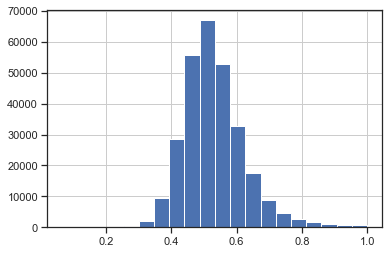

In [57]:
# Plot a histogram of the joined DPM values
# This ignores NaN values, i.e., those buildings for which no DPM value was assigned
dpm_hist = inputs_gdf.DPM_MAX.hist(bins=20)

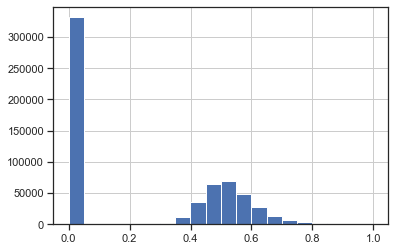

In [58]:
# Assign buildings with no DPM value to a value of DPM=0
inputs_gdf.fillna(value={"DPM_MAX": 0}, inplace=True)
dpm_hist = inputs_gdf.DPM_MAX.hist(bins=20)

## Step 7. Extract the training features and training labels

In [59]:
train_values = inputs_gdf[["MMI", "DPM_MAX"]]
train_labels = inputs_gdf[["DAMAGE_GRADE"]]

In [60]:
train_values.dtypes

MMI        float64
DPM_MAX    float64
dtype: object

In [61]:
train_labels.dtypes

DAMAGE_GRADE    int64
dtype: object

### Explore the training data

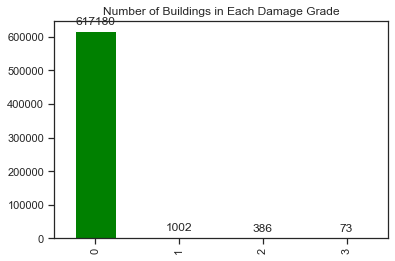

In [62]:
ax = (train_labels.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Number of Buildings in Each Damage Grade",
          color=["Green", "Gold", "Orange", "IndianRed"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

### Select subset of features to use for training

In [63]:
selected_features = ["MMI", "DPM_MAX"]
train_values_subset = train_values[selected_features]

### Explore the relationships between the numeric features and labels

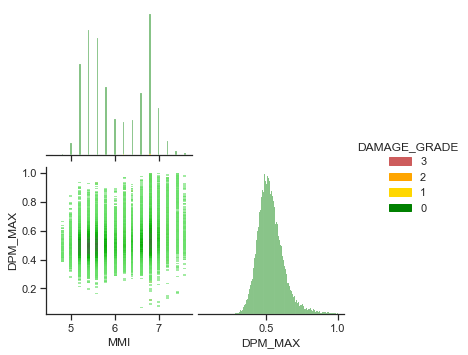

In [64]:
sns.set_theme(style="ticks")
train_values_subset_plot = train_values_subset.replace(0, np.nan)
sns.pairplot(
    train_values_subset_plot.join(train_labels),
    hue="DAMAGE_GRADE",
    hue_order=[3, 2, 1, 0],
    palette={0:"Green", 1:"Gold", 2:"Orange", 3:"IndianRed"},
    markers=["1", "2", "3", "4"],
    kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
)

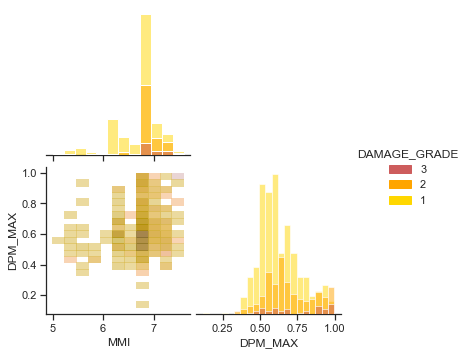

In [65]:
# Ignore Damage Grade 0 for the plots
sns.pairplot(
    train_values_subset_plot.join(train_labels).replace(0, np.nan),
    hue="DAMAGE_GRADE",
    hue_order=[3, 2, 1],
    palette={1:"Gold", 2:"Orange", 3:"IndianRed"},
    markers=["2", "3", "4"],
    kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
)

## Step 8. Build the ML model(s)

### Import modules for the machine learning training component

In [66]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# for splitting the data into training and test sets
from sklearn.model_selection import train_test_split

# the model(s)
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

### Split dataset into training and test subsets

When performing a (supervised) machine learning experiment, it is common to hold out part of the available data as a test set `X_test, y_test`. The best parameters can be determined by grid search techniques.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(train_values_subset, train_labels, train_size=0.70, test_size=0.30, random_state=40)

### Construct a pipeline from the given estimators

In [68]:
pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        random_state=42,
        max_depth=None,
        min_samples_split=2,
        max_features="sqrt"
    )
)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features='sqrt', random_state=42))])

### Train a random forest model with different parameters using grid search

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [69]:
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [70]:
gs.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(max_features='sqrt',
                                                               random_state=42))]),
             param_grid={'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 100]})

### Model with the best parameters

In [71]:
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 50}

In [72]:
# Evaluation metrics
# from sklearn.metrics import roc_curve # restricted to the binary classification case
# from sklearn.metrics import plot_precision_recall_curve # restricted to the binary classification case
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

#### Compute the F1 score, also known as balanced F-score or F-measure for the _training_ set

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

`F1 = 2 * (precision * recall) / (precision + recall)`

In our multi-class case, this is the average of the F1 score of each class with weighting depending on the average parameter.

In [73]:
# Calculate metrics globally by counting the total true positives, 
# false negatives and false positives.
in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.9976383718505563

In [74]:
# Calculate metrics for each label, and find their average weighted 
# the number of true instances for each label. This alters ‘macro’ to 
# account for label imbalance; it can result in an F-score that is not 
# between precision and recall.
f1_score(train_labels, in_sample_preds, average='weighted')

0.9964589537460947

In [75]:
# Calculate metrics for each label, and find their unweighted mean. 
# This does not take label imbalance into account.
f1_score(train_labels, in_sample_preds, average='macro')

0.24970444748875442

#### Print balanced accuracy score for predictions on the _training_ set

The balanced_accuracy_score function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets. It is the macro-average of recall scores per class or, equivalently, raw accuracy where each sample is weighted according to the inverse prevalence of its true class. For balanced datasets, the score is equal to accuracy.

In [76]:
balanced_accuracy_score(train_labels, in_sample_preds)

0.25

#### Print classification report for predictions on the _training_ set
The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [77]:
target_names = ["No Damage", "Slight Damage", "Moderate Damage", "Heavy Damage"]
print(classification_report(train_labels, in_sample_preds, target_names=target_names))

/Users/arao/GEM/Code/venvs/py385/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

      No Damage       1.00      1.00      1.00    617180
  Slight Damage       0.00      0.00      0.00      1002
Moderate Damage       0.00      0.00      0.00       386
   Heavy Damage       0.00      0.00      0.00        73

       accuracy                           1.00    618641
      macro avg       0.25      0.25      0.25    618641
   weighted avg       1.00      1.00      1.00    618641



#### Display the confusion matrix for the predictions on the _training_ set

In [78]:
confusion_matrix(train_labels, in_sample_preds)

array([[617180,      0,      0,      0],
       [  1002,      0,      0,      0],
       [   386,      0,      0,      0],
       [    73,      0,      0,      0]])

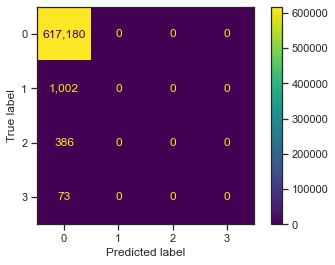

In [79]:
# Plot confusion matrix with absolute, non-normalized values
plot_confusion_matrix(
    gs, train_values_subset, train_labels,
    values_format=",",
    cmap="viridis"
)

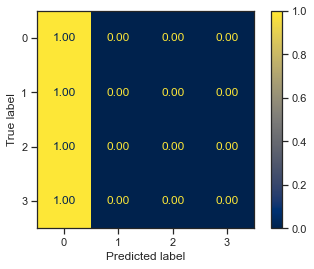

In [80]:
# Plot confusion matrix with normalized values
plot_confusion_matrix(
    gs, train_values_subset, train_labels,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

## Step 9: Use the trained ML model to make predictions on the test set

In [81]:
y_pred = gs.predict(X_test)

#### Display the confusion matrix for the predictions on the _test_ set

In [82]:
confusion_matrix(y_test, y_pred)

array([[185139,      0,      0,      0],
       [   329,      0,      0,      0],
       [   107,      0,      0,      0],
       [    18,      0,      0,      0]])

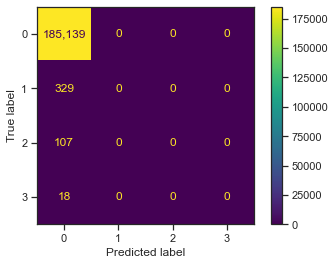

In [83]:
# Plot confusion matrix with absolute, non-normalized values
plot_confusion_matrix(
    gs, X_test, y_test,
    values_format=",",
    cmap="viridis"
)

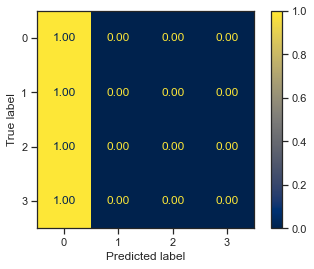

In [84]:
# Plot confusion matrix with normalized values
plot_confusion_matrix(
    gs, X_test, y_test,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

#### Print classification report for the predictions on the _test_ set

In [85]:
target_names = ["No Damage", "Slight Damage", "Moderate Damage", "Heavy Damage"]
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

      No Damage       1.00      1.00      1.00    185139
  Slight Damage       0.00      0.00      0.00       329
Moderate Damage       0.00      0.00      0.00       107
   Heavy Damage       0.00      0.00      0.00        18

       accuracy                           1.00    185593
      macro avg       0.25      0.25      0.25    185593
   weighted avg       1.00      1.00      1.00    185593



/Users/arao/GEM/Code/venvs/py385/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Print balanced accuracy score for the predictions on the _test_ set

In [86]:
balanced_accuracy_score(y_test, y_pred)

0.25

## Step 10. Better handling of the D0 imbalance in the dataset

### Use a Random Forest Classifier with class weights

In [87]:
pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        random_state=42,
        max_depth=None,
        min_samples_split=2,
        max_features="sqrt",
        class_weight="balanced"
    )
)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='sqrt',
                                        random_state=42))])

In [88]:
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs_weighted = GridSearchCV(pipe, param_grid, cv=5)

In [89]:
gs_weighted.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_features='sqrt',
                                                               random_state=42))]),
             param_grid={'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 100]})

In [90]:
gs_weighted.best_params_

{'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__n_estimators': 100}

In [91]:
in_sample_preds = gs_weighted.predict(train_values_subset)

#### Print balanced accuracy score for predictions on the _training_ set

In [92]:
balanced_accuracy_score(train_labels, in_sample_preds)

0.6373199691628958

#### Print classification report for predictions on the _training_ set

In [93]:
target_names = ["No Damage", "Slight Damage", "Moderate Damage", "Heavy Damage"]
print(classification_report(train_labels, in_sample_preds, target_names=target_names))

                 precision    recall  f1-score   support

      No Damage       1.00      0.81      0.89    617180
  Slight Damage       0.01      0.47      0.03      1002
Moderate Damage       0.02      0.46      0.04       386
   Heavy Damage       0.00      0.81      0.00        73

       accuracy                           0.81    618641
      macro avg       0.26      0.64      0.24    618641
   weighted avg       1.00      0.81      0.89    618641



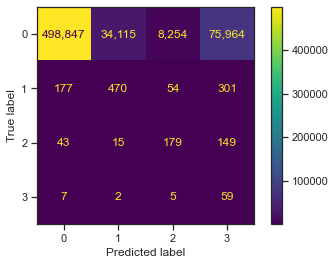

In [94]:
# Plot confusion matrix with absolute, non-normalized values
plot_confusion_matrix(
    gs_weighted, train_values_subset, train_labels,
    values_format=",",
    cmap="viridis"
)

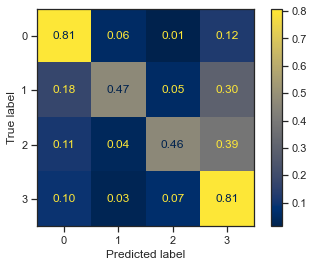

In [95]:
# Plot confusion matrix with normalized values
plot_confusion_matrix(
    gs_weighted, train_values_subset, train_labels,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

#### Use the trained model to make predictions on the test set

In [96]:
y_pred = gs_weighted.predict(X_test)

#### Display the confusion matrix for the predictions on the _test_ set

In [97]:
confusion_matrix(y_test, y_pred)

array([[149578,  10306,   2487,  22768],
       [   152,     72,     11,     94],
       [    41,      4,     15,     47],
       [     7,      1,      2,      8]])

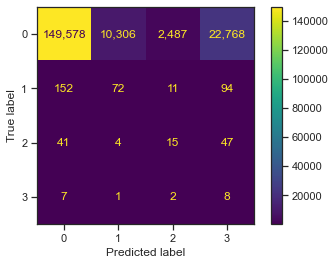

In [98]:
# Plot confusion matrix with absolute, non-normalized values
plot_confusion_matrix(
    gs_weighted, X_test, y_test,
    values_format=",",
    cmap="viridis"
)

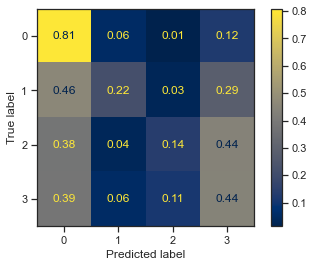

In [99]:
# Plot confusion matrix with normalized values
plot_confusion_matrix(
    gs_weighted, X_test, y_test,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

#### Print classification report for the predictions on the _test_ set

In [100]:
target_names = ["No Damage", "Slight Damage", "Moderate Damage", "Heavy Damage"]
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

      No Damage       1.00      0.81      0.89    185139
  Slight Damage       0.01      0.22      0.01       329
Moderate Damage       0.01      0.14      0.01       107
   Heavy Damage       0.00      0.44      0.00        18

       accuracy                           0.81    185593
      macro avg       0.25      0.40      0.23    185593
   weighted avg       1.00      0.81      0.89    185593



#### Print balanced accuracy score for the predictions on the _test_ set

In [101]:
balanced_accuracy_score(y_test, y_pred)

0.4028497602637722

## Step 11. Try binary classification

### Compress the damage grades into 0 and 1

In [102]:
# Assign buildings with no DPM value to a value of DPM=0
inputs_gdf["DAMAGE_GRADE_BINARY"] = inputs_gdf.DAMAGE_GRADE.apply(lambda x: 0 if x<=1 else 1)

### Extract the training features and training labels

In [103]:
train_values = inputs_gdf[["MMI", "DPM_MAX"]]
train_labels = inputs_gdf[["DAMAGE_GRADE_BINARY"]]

In [104]:
train_values.dtypes

MMI        float64
DPM_MAX    float64
dtype: object

In [105]:
train_labels.dtypes

DAMAGE_GRADE_BINARY    int64
dtype: object

### Explore the training data

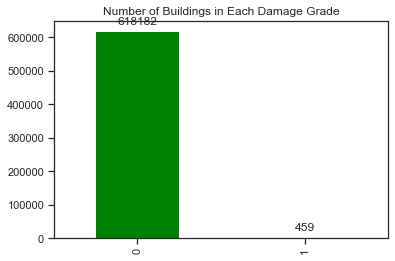

In [106]:
ax = (train_labels.DAMAGE_GRADE_BINARY
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Number of Buildings in Each Damage Grade",
          color=["Green", "Orange"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

### Select subset of features to use for training

In [107]:
selected_features = ["MMI", "DPM_MAX"]
train_values_subset = train_values[selected_features]

### Explore the relationships between the numeric features and labels

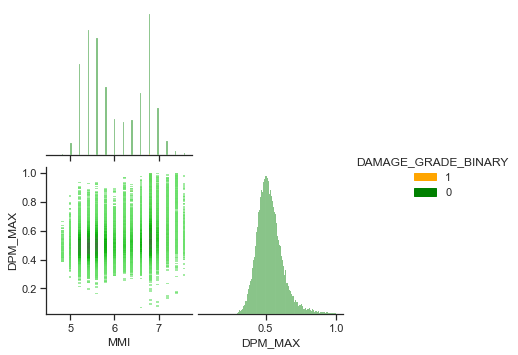

In [108]:
sns.set_theme(style="ticks")
train_values_subset_plot = train_values_subset.replace(0, np.nan)
sns.pairplot(
    train_values_subset_plot.join(train_labels),
    hue="DAMAGE_GRADE_BINARY",
    hue_order=[1, 0],
    palette={0:"Green", 1:"Orange"},
    markers=["1", "2"],
    kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
)

### Split dataset into training and test subsets

When performing a (supervised) machine learning experiment, it is common to hold out part of the available data as a test set `X_test, y_test`. The best parameters can be determined by grid search techniques.

In [109]:
X_train, X_test, y_train, y_test = train_test_split(train_values_subset, train_labels, train_size=0.70, test_size=0.30, random_state=40)

### Use a Random Forest Classifier with class weights

In [110]:
pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        random_state=42,
        max_depth=None,
        min_samples_split=2,
        max_features="sqrt",
        class_weight="balanced"
    )
)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='sqrt',
                                        random_state=42))])

In [111]:
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs_binary = GridSearchCV(pipe, param_grid, cv=5)

In [112]:
gs_binary.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_features='sqrt',
                                                               random_state=42))]),
             param_grid={'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 100]})

In [113]:
gs_binary.best_params_

{'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__n_estimators': 50}

In [114]:
in_sample_preds = gs_binary.predict(train_values_subset)

#### Print balanced accuracy score for predictions on the _training_ set

In [115]:
balanced_accuracy_score(train_labels, in_sample_preds)

0.8564295626033773

#### Print classification report for predictions on the _training_ set

In [116]:
target_names = ["No Damage", "Damage"]
print(classification_report(train_labels, in_sample_preds, target_names=target_names))

              precision    recall  f1-score   support

   No Damage       1.00      0.86      0.93    618182
      Damage       0.00      0.85      0.01       459

    accuracy                           0.86    618641
   macro avg       0.50      0.86      0.47    618641
weighted avg       1.00      0.86      0.93    618641



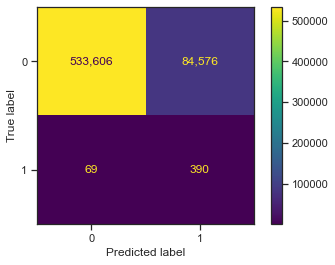

In [117]:
# Plot confusion matrix with absolute, non-normalized values
plot_confusion_matrix(
    gs_binary, train_values_subset, train_labels,
    values_format=",",
    cmap="viridis"
)

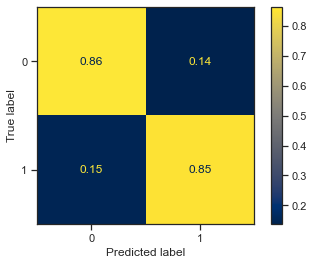

In [118]:
# Plot confusion matrix with normalized values
plot_confusion_matrix(
    gs_binary, train_values_subset, train_labels,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

#### Use the trained model to make predictions on the test set

In [119]:
y_pred = gs_binary.predict(X_test)

#### Display the confusion matrix for the predictions on the _test_ set

In [120]:
confusion_matrix(y_test, y_pred)

array([[160109,  25359],
       [    53,     72]])

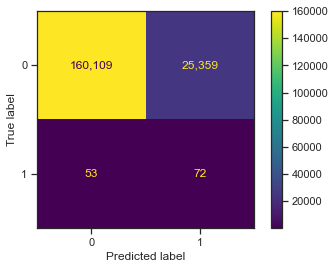

In [121]:
# Plot confusion matrix with absolute, non-normalized values
plot_confusion_matrix(
    gs_binary, X_test, y_test,
    values_format=",",
    cmap="viridis"
)

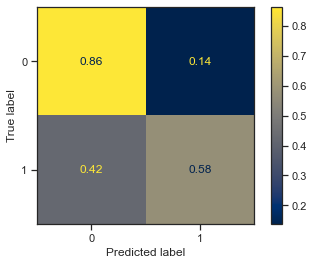

In [122]:
# Plot confusion matrix with normalized values
plot_confusion_matrix(
    gs_binary, X_test, y_test,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

#### Print classification report for the predictions on the _test_ set

In [123]:
target_names = ["No Damage", "Damage"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No Damage       1.00      0.86      0.93    185468
      Damage       0.00      0.58      0.01       125

    accuracy                           0.86    185593
   macro avg       0.50      0.72      0.47    185593
weighted avg       1.00      0.86      0.93    185593



#### Print balanced accuracy score for the predictions on the _test_ set

In [124]:
balanced_accuracy_score(y_test, y_pred)

0.719635106864796